# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
2. Click on the restart and run kernel icon for ipython


Notes: 
* add variable number of relay requests to allow for what if
* new pr with analytical solutions
* minimum honest vs signature threshold

In [1]:
import random
import simpy
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt
import simulation_functions as sc

**Initialize Variables**

In [2]:
group_size = 20 # number of nodes in a group
nodes = 100 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
signature_threshold = 10  # min number of nodes needed to sign 
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 10 #number of steps after which a group expires
node_failure_percent = 50 # % of times nodes fail and have to reconnect
node_death_percent = 5 # % of time nodes fail and do not reconnect


Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

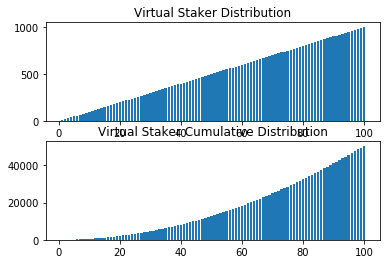

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=sc.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

In [4]:
beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  signature_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay
                                 )

In [5]:
active_group_size = []
signature_failures = []
for i in range (200):
    beacon_model.step()
    active_group_size.append(len(beacon_model.active_groups))
    print("signature failure events")
    print(beacon_model.unsuccessful_signature_events)
    

step # = 0
refreshing active nodes list
Number of nodes in the forked state = 0
bootstrapping active groups
number of active groups = 0
relay request recieved? = True
     selecting group at random
low >= high
     no active groups available
     registering new group
             Not enough nodes to register a group
signature failure events
[]
step # = 1
refreshing active nodes list
Number of nodes in the forked state = 24
bootstrapping active groups
number of active groups = 10
group ID 0status = Activesteps to expiry = 10
group ID 1status = Activesteps to expiry = 10
group ID 2status = Activesteps to expiry = 10
group ID 3status = Activesteps to expiry = 10
group ID 4status = Activesteps to expiry = 10
group ID 5status = Activesteps to expiry = 10
group ID 6status = Activesteps to expiry = 10
group ID 7status = Activesteps to expiry = 10
group ID 8status = Activesteps to expiry = 10
group ID 9status = Activesteps to expiry = 10
relay request recieved? = False
     No relay request
s

Signature ID 128 Delay = 1
Signature ID 130 Delay = 3
Starting signature process for signature ID = 132
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 30
refreshing active nodes list
Number of nodes in the forked state = 45
number of active groups = 5
group ID 0status = Expiredsteps to expiry = -19
group ID 1status = Expiredsteps to expiry = -19
group ID 2status = Expiredsteps to expiry = -19
group ID 3status = Expiredsteps to expiry = -19
group ID 4status = Expiredsteps to expiry = -19
group ID 5status = Expiredsteps to expiry = -19
group ID 6status = Expiredsteps to expiry = -19
group ID 7status = Expiredsteps to expiry = -19
group ID 8status = Expiredsteps to expiry = -19
group ID 9status = Expiredsteps to expiry = -19
group ID 10status = Expiredsteps to expiry = -15
group ID 11status = Expiredsteps to expiry = -12
group ID 12status = Expiredsteps to expiry = -9
group ID 13status = Expiredsteps to expiry = -8
group ID 14status = Expiredsteps to expiry = -6
group ID 15

Signature ID 152 Delay = 3
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 54
refreshing active nodes list
Number of nodes in the forked state = 52
number of active groups = 5
group ID 0status = Expiredsteps to expiry = -43
group ID 1status = Expiredsteps to expiry = -43
group ID 2status = Expiredsteps to expiry = -43
group ID 3status = Expiredsteps to expiry = -43
group ID 4status = Expiredsteps to expiry = -43
group ID 5status = Expiredsteps to expiry = -43
group ID 6status = Expiredsteps to expiry = -43
group ID 7status = Expiredsteps to expiry = -43
group ID 8status = Expiredsteps to expiry = -43
group ID 9status = Expiredsteps to expiry = -43
group ID 10status = Expiredsteps to expiry = -39
group ID 11status = Expiredsteps to expiry = -36
group ID 12status = Expiredsteps to expiry = -33
group ID 13status = Expiredsteps to expiry = -32
group ID 14status = Expiredsteps to expiry = -30
group ID 15status = Expiredsteps to expiry = -29
gro

     Checking for active nodes in randomly selected group
         signature successful
Signature ID 176 Delay = 2
Starting signature process for signature ID = 178
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 76
refreshing active nodes list
Number of nodes in the forked state = 47
number of active groups = 5
group ID 0status = Expiredsteps to expiry = -65
group ID 1status = Expiredsteps to expiry = -65
group ID 2status = Expiredsteps to expiry = -65
group ID 3status = Expiredsteps to expiry = -65
group ID 4status = Expiredsteps to expiry = -65
group ID 5status = Expiredsteps to expiry = -65
group ID 6status = Expiredsteps to expiry = -65
group ID 7status = Expiredsteps to expiry = -65
group ID 8status = Expiredsteps to expiry = -65
group ID 9status = Expiredsteps to expiry = -65
group ID 10status = Expiredsteps to expiry = -61
group ID 11status = Expiredsteps to expiry = -58
group ID 12status = Ex

group ID 21status = Expiredsteps to expiry = -60
group ID 22status = Expiredsteps to expiry = -59
group ID 23status = Expiredsteps to expiry = -57
group ID 24status = Expiredsteps to expiry = -50
group ID 25status = Expiredsteps to expiry = -47
group ID 26status = Expiredsteps to expiry = -46
group ID 27status = Expiredsteps to expiry = -43
group ID 28status = Expiredsteps to expiry = -42
group ID 29status = Expiredsteps to expiry = -40
group ID 30status = Expiredsteps to expiry = -38
group ID 31status = Expiredsteps to expiry = -37
group ID 32status = Expiredsteps to expiry = -33
group ID 33status = Expiredsteps to expiry = -32
group ID 34status = Expiredsteps to expiry = -31
group ID 35status = Expiredsteps to expiry = -30
group ID 36status = Expiredsteps to expiry = -29
group ID 37status = Expiredsteps to expiry = -27
group ID 38status = Expiredsteps to expiry = -25
group ID 39status = Expiredsteps to expiry = -24
group ID 40status = Expiredsteps to expiry = -21
group ID 41status = 

group ID 56status = Expiredsteps to expiry = -4
group ID 57status = Expiredsteps to expiry = -3
group ID 58status = Expiredsteps to expiry = -1
group ID 59status = Activesteps to expiry = 1
group ID 60status = Activesteps to expiry = 3
group ID 61status = Activesteps to expiry = 4
group ID 62status = Activesteps to expiry = 5
group ID 63status = Activesteps to expiry = 6
group ID 64status = Activesteps to expiry = 8
group ID 65status = Activesteps to expiry = 9
relay request recieved? = False
     No relay request
     Checking for active nodes in randomly selected group
         signature successful
Signature ID 218 Delay = 3
Signature ID 220 Delay = 1
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 116
refreshing active nodes list
Number of nodes in the forked state = 44
number of active groups = 6
group ID 0status = Expiredsteps to expi

group ID 36status = Expiredsteps to expiry = -62
group ID 37status = Expiredsteps to expiry = -60
group ID 38status = Expiredsteps to expiry = -58
group ID 39status = Expiredsteps to expiry = -57
group ID 40status = Expiredsteps to expiry = -54
group ID 41status = Expiredsteps to expiry = -51
group ID 42status = Expiredsteps to expiry = -50
group ID 43status = Expiredsteps to expiry = -48
group ID 44status = Expiredsteps to expiry = -47
group ID 45status = Expiredsteps to expiry = -43
group ID 46status = Expiredsteps to expiry = -42
group ID 47status = Expiredsteps to expiry = -41
group ID 48status = Expiredsteps to expiry = -40
group ID 49status = Expiredsteps to expiry = -35
group ID 50status = Expiredsteps to expiry = -32
group ID 51status = Expiredsteps to expiry = -29
group ID 52status = Expiredsteps to expiry = -28
group ID 53status = Expiredsteps to expiry = -24
group ID 54status = Expiredsteps to expiry = -23
group ID 55status = Expiredsteps to expiry = -22
group ID 56status = 

Signature ID 252 Delay = 3
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 150
refreshing active nodes list
Number of nodes in the forked state = 42
number of active groups = 4
group ID 0status = Expiredsteps to expiry = -139
group ID 1status = Expiredsteps to expiry = -139
group ID 2status = Expiredsteps to expiry = -139
group ID 3status = Expiredsteps to expiry = -139
group ID 4status = Expiredsteps to expiry = -139
group ID 5status = Expiredsteps to expiry = -139
group ID 6status = Expiredsteps to expiry = -139
group ID 7status = Expiredsteps to expiry = -139
group ID 8status = Expiredsteps to expiry = -139
group ID 9status = Expiredsteps to expiry = -139
group ID 10status = Expiredsteps to expiry = -135
group ID 11status = Expiredsteps to expiry = -132
group ID 12status = Expiredsteps to 

Signature ID 268 Delay = 2
Signature ID 270 Delay = 2
Starting signature process for signature ID = 272
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 165
refreshing active nodes list
Number of nodes in the forked state = 44
number of active groups = 6
group ID 0status = Expiredsteps to expiry = -154
group ID 1status = Expiredsteps to expiry = -154
group ID 2status = Expiredsteps to expiry = -154
group ID 3status = Expiredsteps to expiry = -154
group ID 4status = Expiredsteps to expiry = -154
group ID 5status = Expiredsteps to expiry = -154
group ID 6status = Expiredsteps to expiry = -154
group ID 7status = Expiredsteps to expiry = -154
group ID 8status = Expiredsteps to expiry = -154
group ID 9status = Expiredsteps to expiry = -154
group ID 10status = Expiredsteps

     Checking for active nodes in randomly selected group
         signature successful
Starting signature process for signature ID = 284
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 181
refreshing active nodes list
Number of nodes in the forked state = 51
number of active groups = 4
group ID 0status = Expiredsteps to expiry = -170
group ID 1status = Expiredsteps to expiry = -170
group ID 2status = Expiredsteps to expiry = -170
group ID 3status = Expiredsteps to expiry = -170
group ID 4status = Expiredsteps to expiry = -170
group ID 5status = Expiredsteps to expiry = -170
group ID 6status = Expiredsteps to expiry = -170
group ID 7status = Expiredsteps to expiry = -170
group ID 8status = Expiredsteps to expiry = -170
group ID 9status = Expi

group ID 101status = Activesteps to expiry = 1
group ID 102status = Activesteps to expiry = 6
group ID 103status = Activesteps to expiry = 7
group ID 104status = Activesteps to expiry = 8
relay request recieved? = True
     selecting group at random
     registering new group
     Checking for active nodes in randomly selected group
         signature successful
Signature ID 298 Delay = 1
Starting signature process for signature ID = 300
signature failure events
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
step # = 196
refreshing active nodes list
Number of nodes in the forked state = 42
number of active groups = 4
group ID 0status = Expiredsteps to expiry = -185
group ID 1status = Expiredsteps to expiry = -185
group ID 2status = Expiredsteps to expiry

5.0


Text(0, 0.5, 'Signature failure events')

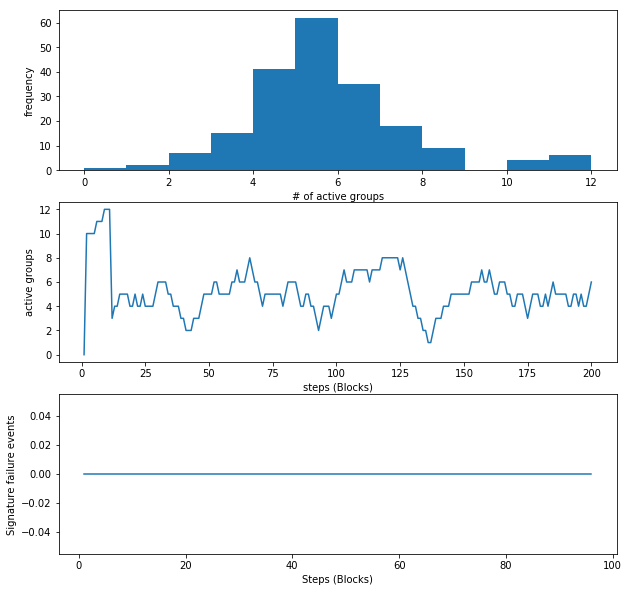

In [6]:
plt.figure(figsize = (10,10))
plt.subplot(3, 1, 1)
plt.hist(active_group_size, bins=range(max(active_group_size)+1))
plt.xlabel("# of active groups")
plt.ylabel("frequency")
print(np.median(active_group_size))

plt.subplot(3, 1, 2)
plt.plot(np.linspace(1,len(active_group_size),len(active_group_size)),active_group_size)
plt.xlabel("steps (Blocks)")
plt.ylabel("active groups")

plt.subplot(3, 1, 3)
plt.plot(np.linspace(1,len(beacon_model.unsuccessful_signature_events),
                     len(beacon_model.unsuccessful_signature_events)),
                     beacon_model.unsuccessful_signature_events)
plt.xlabel("Steps (Blocks)")
plt.ylabel("Signature failure events")

Median Group ownership = 10.0
Median Signature ownership = 10.0


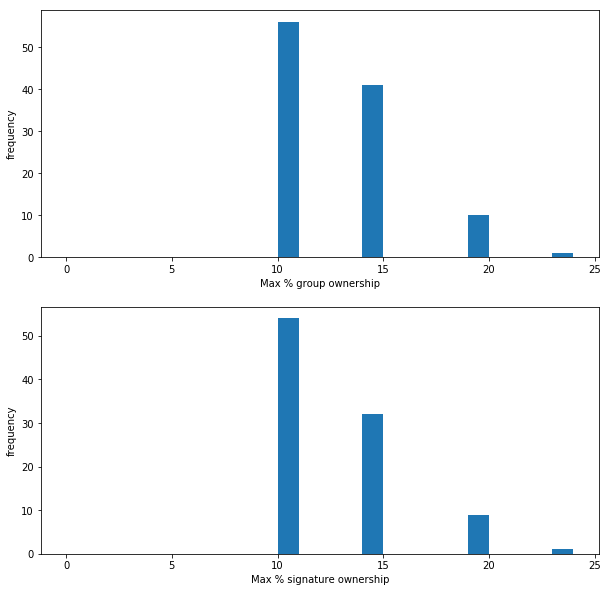

In [7]:

max_group_ownership = []
for group in beacon_model.schedule.agents:
    if group.type == "group":
        #print(group.ownership_distr)
        #print(max(group.ownership_distr)/sum(group.ownership_distr))
        max_group_ownership.append(int(round(max(group.ownership_distr)/sum(group.ownership_distr)*100)))

plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(max_group_ownership, bins=range(max(max_group_ownership)+1))
plt.xlabel("Max % group ownership")
plt.ylabel("frequency")
print("Median Group ownership = " + str(np.median(max_group_ownership)))

max_signature_ownership = []
for signature in beacon_model.schedule.agents:
    if signature.type == "signature" and signature.end_signature_process:
        #print(signature.id)
        #print(signature.ownership_distr)
        max_signature_ownership.append(int(round(max(signature.ownership_distr)/sum(signature.ownership_distr)*100)))

plt.subplot(2, 1, 2)
plt.hist(max_signature_ownership, bins=range(max(max_signature_ownership)+1))
plt.xlabel("Max % signature ownership")
plt.ylabel("frequency")
print("Median Signature ownership = " + str(np.median(max_signature_ownership)))

**Further Questions**

* Whats the distribution of group ownership for each node that owns at least 1 group

Text(0, 0.5, 'frequency')

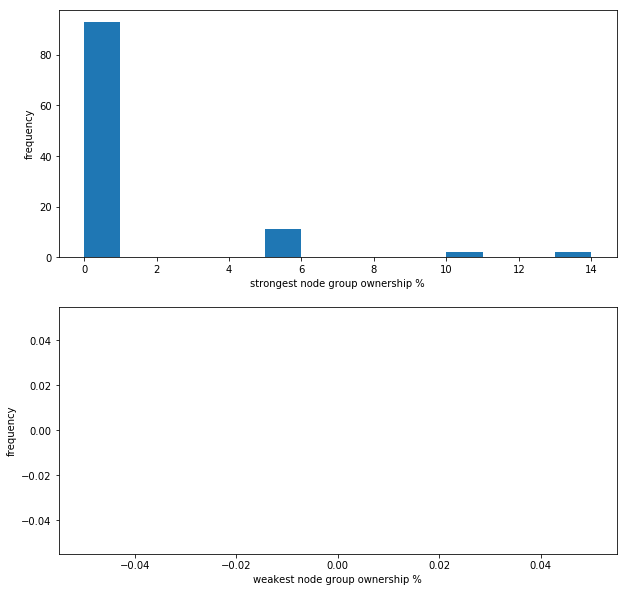

In [11]:
# Calculate ownership distributions per node by calculating the node's % ownership of each group
node_ownership_percent= []
for node in beacon_model.schedule.agents:
    if node.type == "node":
        temp = []
        for group in beacon_model.schedule.agents:
            if group.type == "group":
                temp.append(round(group.ownership_distr[node.id]/sum(group.ownership_distr)*100))
        node_ownership_percent.append(temp)

strongest_node = node_ownership_percent.index(max(node_ownership_percent))
weakest_node = node_ownership_percent.index(min(node_ownership_percent))

plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(node_ownership_percent[strongest_node], bins=range(int(max(node_ownership_percent[strongest_node]))+1))
plt.xlabel("strongest node group ownership %")
plt.ylabel("frequency")

plt.subplot(2, 1, 2)
plt.hist(node_ownership_percent[weakest_node], bins=range(int(max(node_ownership_percent[weakest_node]))+1))
plt.xlabel("weakest node group ownership %")
plt.ylabel("frequency")


* what % of nodes own at least 1 group

In [9]:
# count the number of nodes that have no group ownerhship at all, subtract from one to get answer
no_ownership_count = 0
for node in node_ownership_percent:
    if sum(node)==0:
        no_ownership_count +=1
        
print(1-no_ownership_count/nodes)

0.97


* How many of the signatures produces have a single actor in control
* control = 

[100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100, 100, 0, 100, 100, 100, 0, 100, 0, 0, 100, 100, 0, 100, 100, 0, 100, 100, 100, 100, 100, 100, 100, 0, 100, 100, 100, 0, 100, 100, 100, 0, 100, 100, 0, 0, 100, 0, 100, 100, 100, 0, 100, 100, 100, 0, 100, 100, 100, 0, 0, 100, 100, 100, 0, 100, 100, 0, 100, 0, 100, 0, 0, 100, 100, 100, 100, 100, 0, 100, 100, 100, 0, 100, 100, 0, 100, 100, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 100, 100, 0, 100, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 3, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 3, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 4, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 3, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 3, 0, 2, 1, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 2, 4, 1, 0, 2, 1, 0, 1, 0

Text(0, 0.5, 'frequency')

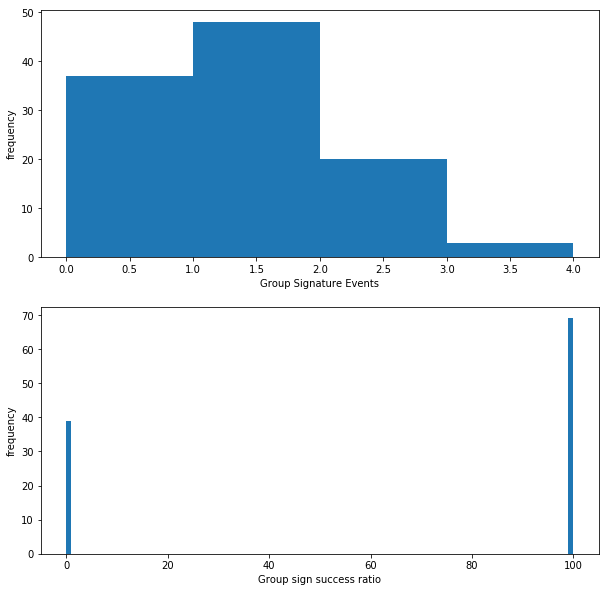

In [10]:
# for each group count the number of successful signature events 
group_signature_events = []
group_successes = []
group_sign_ratio = []
for group in beacon_model.schedule.agents:
    if group.type == "group":
        group_sign_total = 0
        group_sign_successes = 0
        #print("group id = "+str(group.id))
        for signature in beacon_model.schedule.agents:
            if signature.type == "signature":
                #print("signature id = "+str(signature.id))
                if signature.group.id == group.id:
                    group_sign_total +=1 # count the total number of signature events this group participates in
                    group_sign_successes += signature.signature_success # count the number of successes
        group_signature_events.append(group_sign_total)
        group_successes.append(group_sign_successes)
        if group_sign_total>0:
            group_sign_ratio.append(round(group_sign_successes/group_sign_total*100))
        else:
            group_sign_ratio.append(0)

print(group_sign_ratio)
print(group_signature_events)
print(group_successes)
            
    
plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(group_signature_events, bins=range(int(max(group_signature_events))+1))
plt.xlabel("Group Signature Events")
plt.ylabel("frequency")

plt.subplot(2, 1, 2)
plt.hist(group_sign_ratio, bins=range(int(max(group_sign_ratio))+1))
plt.xlabel("Group sign success ratio")
plt.ylabel("frequency")

